In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
from tqdm import tqdm
import scipy as sp
from copy import deepcopy 

# LISA tools
from lisatools.utils.constants import *
from lisatools.sensitivity  import AE1SensitivityMatrix, AET1SensitivityMatrix

# BBHX: Suppress the print statements from the BBHX module like: "No CuPy or GPU PhenomHM module"
# This is done to avoid cluttering the output when running sp.optimize.differential_evolution
from contextlib import contextmanager

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

with suppress_stdout():
    from bbhx.waveformbuild import BBHWaveformFD

# My modules
from tools.LISASimulator import LISASimulator
from tools.time_freq_likelihood import TimeFreqLikelihood
from tools.likelihood import get_dh, get_hh, TimeFreqSNR
import tools.likelihood as likelihood
from tools.MBHB_differential_evolution import MBHB_finder_time_frequency, MBHB_finder_lisatools, MBHB_finder_frequency_domain, transform_bbhx_to_parameters, transform_parameters_to_bbhx, transform_parameters_to_bbhx_dictionary

In [2]:
from multiprocessing import cpu_count
print(cpu_count())

11


In [3]:
Tobs = YRSID_SI/12
dt = 5.
include_T_channel = False # Set to True if you want to include the T channel in the simulation, otherwise only A and E channels will be included.

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

m1 = 3e5
m2 = 1.5e5
a1 = 0.2
a2 = 0.4
dist = 4 * PC_SI * 1e9  # distance in Gpc
phi_ref = np.pi/2
f_ref = 0.0
inc = np.pi/3
lam = np.pi/1.
beta = np.pi/4.
psi = np.pi/4.
t_ref = 0.95 * Tobs
#t_ref = round(0.9 * Tobs / dt) * dt  # round to the nearest multiple of dt, to force t_ref to be a part of t_array

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

m1_2 = 8e5 # 1e5
m2_2 = 2e5 # 1e5
a1_2 = 0.5
a2_2 = 0.7
dist_2 = 200 * 1e9 * PC_SI # lower distance try this 
phi_ref_2 = 0.0
f_ref_2 = 0.0
inc_2 = np.pi/3.
lam_2 = np.pi  # ecliptic longitude
beta_2 = np.pi/2. # ecliptic latitude
psi_2 = np.pi/6.  # polarization angle
t_ref_2 = 0.95 * Tobs

parameters_2 = np.array([m1_2, m2_2, a1_2, a2_2, dist_2, phi_ref_2, f_ref_2, inc_2, lam_2, beta_2, psi_2, t_ref_2])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(length=1024, direct=False, fill=True, squeeze=False, modes=modes)

data_t, data_f, f_array, t_array, sens_mat = sim(seed = 42, parameters=parameters, waveform_kwargs=waveform_kwargs)
waveform_kwargs.update(freqs=f_array)

print(sim.SNR_optimal()[0])

3595.48440646233


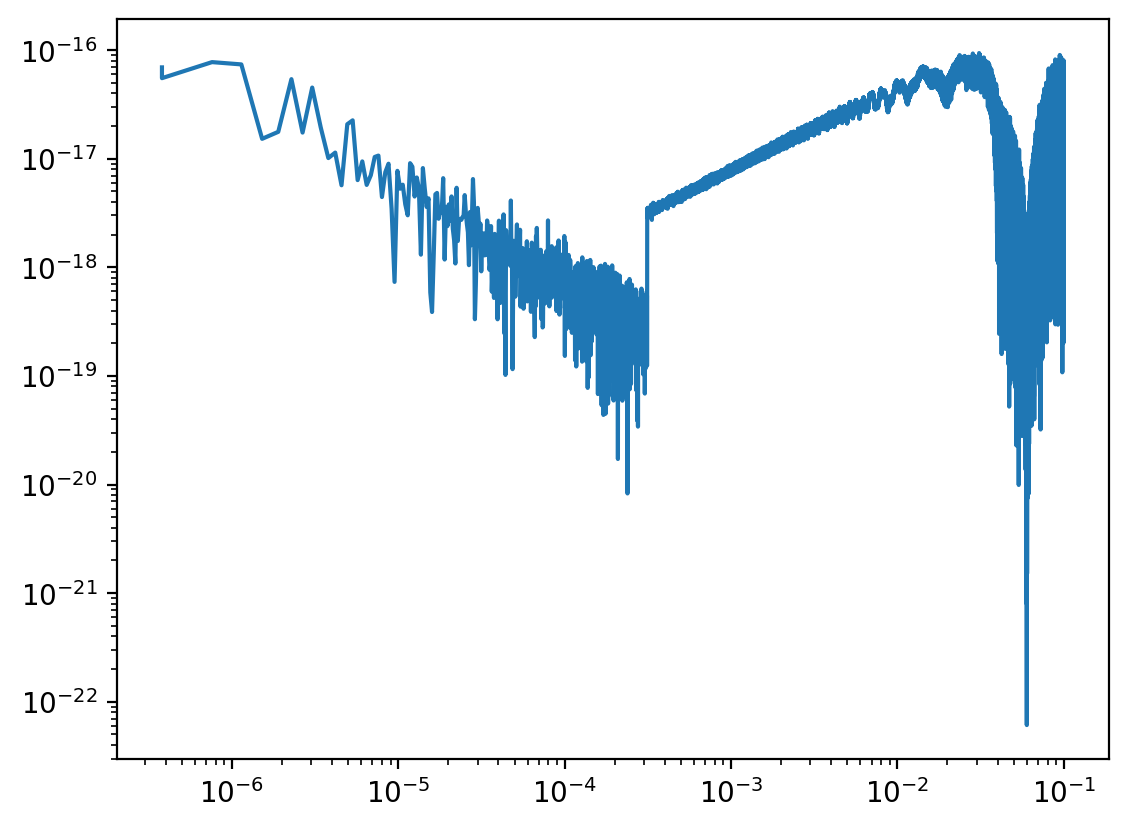

In [4]:
#plt.plot(t_array[:10000], data_t[0][:10000])
plt.loglog(f_array, np.abs(data_f[0]), label="A channel")


## Pre-Merger

In [5]:
# Not doing the premerger now to see if the code works better with the merger included
time_before_merger = 60*60
cutoff_time = t_ref - time_before_merger
max_time = t_ref + 60*60*12

def pre_merger(gravitational_wave_data_t, time_before_merger, t_ref, t_array):
        cutoff_time = t_ref - time_before_merger
        cutoff_index = np.searchsorted(t_array, cutoff_time)
        data_t_truncated = gravitational_wave_data_t[:, :cutoff_index]
        return data_t_truncated, cutoff_index

data_t_truncated,   cutoff_index =  pre_merger(data_t, time_before_merger, t_ref, t_array)
signal_t_truncated, cutoff_index =  pre_merger(sim.signal_t[0], time_before_merger, t_ref, t_array)

# Differential Evolution Analysis

In [6]:
boundaries = {}
boundaries['Total_Mass'] = [1e5, 6e5]   
boundaries['Mass_Ratio'] = [0.05, 0.999999]
boundaries['Spin1'] = [-1, 1]
boundaries['Spin2'] = [-1, 1]
boundaries['Distance'] = [1e3, 10e3] # in Mpc i.e. dL / (PC_SI * 1e6)
boundaries['Phase'] = [0.0, 2 * np.pi]
boundaries['cos(Inclination)'] = [-1, 1]
boundaries['Ecliptic_Longitude'] = [0, 2*np.pi]
boundaries['sin(Ecliptic_Latitude)'] = [-1, 1]
boundaries['Polarization'] = [0, np.pi]
boundaries['Coalescence_Time'] = [cutoff_time, max_time]  

In [28]:
number_of_searches = 1

differential_evolution_kwargs = {
    'strategy': 'best1exp',
    'popsize': 10,
    'tol': 1e-5,
    'maxiter': 10,
    'recombination': 1,
    'mutation': (0.5, 1.0),
    'polish': False,
    'disp': True,
    'workers': -1,  # Use all available CPU cores
    'updating': 'deferred',
}

fixed_parameters = {
    'Total_Mass': m1 + m2,
    'Mass_Ratio': m2 / m1,
    'Spin1': a1,
    'Spin2': a2,
    'Distance': boundaries['Distance'][0] + 0.5 * (boundaries['Distance'][1] - boundaries['Distance'][0]), # Always include distance in fixed parameters
    'Phase': phi_ref,
    'cos(Inclination)': np.cos(inc),
    #'Ecliptic_Longitude': lam,
    #'sin(Ecliptic_Latitude)': np.sin(beta),
    'Polarization': psi,
    'Coalescence_Time': t_ref,
}

bbhx_parameter_names = [
    'm1',
    'm2',
    'chi1z',
    'chi2z',
    'distance',
    'phi_ref',
    'f_ref',
    'inc',
    'lam',
    'beta',
    'psi',
    't_ref'
]


## Time - Frequency Domain

In [29]:
analysis = TimeFreqSNR(
    sim.signal_t[0],
    wave_gen=wave_gen,
    nperseg=5000,
    dt_full=dt,
    cutoff_index=cutoff_index,
    pre_merger=False
)
analysis.get_stft_of_data()
SNR, amplitude = analysis.calculate_time_frequency_SNR(*parameters, waveform_kwargs=waveform_kwargs)
new_distance = dist /  amplitude
print((new_distance - dist)/(PC_SI*1e9) , (new_distance-dist)/dist)
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = ",  SNR)

0.0 0.0
True distance       =  4.0 Gpc
Dist from Amplitude =  4.0 Gpc
SNR calculated      =  1.2772543789153916


In [30]:
# For full signal, use data_t =  sim.signal_t[0] , set pre_merger=False, and comment   cutoff_index = cutoff_index
# For pre-merger,  use data_t =  data_t_truncated, set pre_merger=True , and uncomment cutoff_index = cutoff_index
DifferentialEvolution = MBHB_finder_time_frequency(
    data_t = sim.signal_t[0],
    wave_gen= wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    nperseg=5000,
    dt_full= dt,
    pre_merger=False,
    #cutoff_index=cutoff_index,
    true_parameters=parameters,
)
DifferentialEvolution.get_stft_of_data()

In [31]:
variable_parameter_names =[name for name in boundaries.keys() if name not in fixed_parameters]
bounds = np.array([boundaries[name] for name in variable_parameter_names])
print('bounds', bounds)

# get a random initial guess for the variable parameters from bounds 
variable_parameters = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1])
#variable_parameters = np.array([lam, np.sin(beta)])
print('initial guess', variable_parameters)

variable_parameter_dictionary = {name: variable_parameters[i] for i, name in enumerate(variable_parameter_names)}
#print('variable parameter dictionary', variable_parameter_dictionary)

combined_dictionary = {**fixed_parameters, **variable_parameter_dictionary}
#print('combined dictionary', combined_dictionary)

bbhx_variables = transform_parameters_to_bbhx_dictionary(combined_dictionary)
#wave_gen(**bbhx_variables, **waveform_kwargs)[0][:2]

DifferentialEvolution.calculate_time_frequency_SNR_without_distance(variable_parameters=variable_parameters, fixed_parameters=fixed_parameters, variable_parameter_names=variable_parameter_names)

bounds [[ 0.          6.28318531]
 [-1.          1.        ]]
initial guess [ 1.07959303 -0.52057734]


np.float64(0.0012085459980871393)

In [33]:
found_parameters, found_snr_found, results = DifferentialEvolution.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs, 
                                                                             fixed_transformed_parameters=fixed_parameters)
# The number of messages like "No CuPy or GPU PhenomHM module" you see is exactly equal to the number of workers used. On this macbook, it has 11 cores, so there are 11 messages. Imma just live with this

time SNR  0.28
initial guess 6.90574177721933e-05
No CuPy
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.
No CuPy
No CuPy or GPU PhenomH

In [27]:
print(results)

[             message: Maximum number of iterations has been exceeded.
             success: False
                 fun: -1.2224274914783888
                   x: [ 7.010e-01]
                 nit: 10
                nfev: 110
          population: [[ 7.010e-01]
                       [ 6.795e-01]
                       [ 6.856e-01]
                       [ 7.391e-01]
                       [ 7.384e-01]
                       [ 7.459e-01]
                       [ 6.751e-01]
                       [ 6.337e-01]
                       [ 6.636e-01]
                       [ 6.699e-01]]
 population_energies: [-1.222e+00 -7.225e-01 -8.531e-01 -5.841e-01
                       -5.981e-01 -4.257e-01 -6.395e-01 -1.609e-03
                       -4.249e-01 -5.439e-01]]


In [14]:
import os
os.system("say 'Computation is done!'")

0

## Frequency Domain

In [ ]:
number_of_searches = 1

differential_evolution_kwargs = {
    'strategy': 'best1exp',
    'popsize': 10,
    'tol': 1e-5,
    'maxiter': 50,
    'recombination': 1,
    'mutation': (0.5, 1.0),
    'polish': True,
    'disp': True,
    'workers': -1,  # Use all available CPU cores
    'updating': 'deferred',
}

fixed_parameters = {
    #'Total_Mass': m1 + m2,
    #'Mass_Ratio': m2 / m1,
    #'Spin1': a1,
    #'Spin2': a2,
    'Distance': boundaries['Distance'][0] + 0.5 * (boundaries['Distance'][1] - boundaries['Distance'][0]), # Always include distance in fixed parameters
    #'Phase': phi_ref,
    #'cos(Inclination)': np.cos(inc),
    #'Ecliptic_Longitude': lam,
    #'sin(Ecliptic_Latitude)': np.sin(beta),
    #'Polarization': psi,
    #'Coalescence_Time': t_ref,
}

bbhx_parameter_names = [
    'm1',
    'm2',
    'chi1z',
    'chi2z',
    'distance',
    'phi_ref',
    'f_ref',
    'inc',
    'lam',
    'beta',
    'psi',
    't_ref'
]


In [ ]:
DifferentialEvolution_frequency_domain= MBHB_finder_frequency_domain(
    data_f=data_f,
    wave_gen=wave_gen,
    waveform_kwargs=waveform_kwargs,
    boundaries=boundaries,
    true_parameters=parameters,
)

DifferentialEvolution_frequency_domain.prepare_data(f_array=f_array, df=sim.df)
DifferentialEvolution_frequency_domain.calculate_time_frequency_SNR_with_distance(transform_bbhx_to_parameters(parameters))

In [ ]:
found_parameters_fd, found_snr_found_fd, results_fd = DifferentialEvolution_frequency_domain.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs, 
                                                                             fixed_parameters=fixed_parameters)

In [ ]:
print(DifferentialEvolution_frequency_domain), results_fd

## Lisatools

In [ ]:
DifferentialEvolution_lisatools= MBHB_finder_lisatools(
    data_f=data_f,
    sens_mat=AE1SensitivityMatrix(f=f_array),
    wave_gen=wave_gen,
    waveform_kwargs=waveform_kwargs,
    f_array=f_array,
    boundaries=boundaries,
    true_parameters=parameters,
)


DifferentialEvolution_lisatools.get_analysis_container_of_data()

found_parameters_lisatools, found_snr_found_lisatools, results_lisatools = DifferentialEvolution_lisatools.find_MBHB(number_of_searches=number_of_searches,
                                                                             differential_evolution_kwargs=differential_evolution_kwargs, 
                                                                             fixed_parameters=fixed_parameters)
# The number of messages like "No CuPy or GPU PhenomHM module" you see is exactly equal to the number of workers used. On this macbook, it has 11 cores, so there are 11 messages. Imma just live with this

In [ ]:
print(DifferentialEvolution_lisatools)
print(results_lisatools)

- The reason why the distance estimate can be so bad (sometimes even outside the priors) is because it is calculated from the amplitude that is calculated with a template generated by the other found parameters
- The other found parameters don't have to be close to the true parameters, unless you run it for longer
- With low tolarance, high popsize, and high maxiter, it works properly but takes a long time to run

# The SNR does not depend on the distance. 
Change the guess_distance to see that the SNR is the same. The distance is calculated based on the amplitude.
- This only works when all the other parameters in template are set to the real values. 
- The hope is to use differential_evolution to calculate the remaining parameters reasonably well and get an estimate of distance from that

In [ ]:
guess_distance = dist * 1000
signal_with_which_to_test_this = sim.signal_f[0] #data_f
template = wave_gen(
    m1,
    m2,
    a1,
    a2,
    guess_distance, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    **waveform_kwargs
)
template = template[0, :2]
print(likelihood.template_snr(signal_with_which_to_test_this, template, AE1SensitivityMatrix(f_array), df=sim.df))

hh = get_hh(template, AE1SensitivityMatrix(f_array), df=sim.df)
dh = get_dh(signal_with_which_to_test_this, template, AE1SensitivityMatrix(f_array), df=sim.df)
amplitude = dh/hh
new_distance = guess_distance /  amplitude

print( "Percentage diff     = ", (new_distance-dist)*100/dist , "%" )
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = " , dh/np.sqrt(hh))

The SNR also does not change with the time-frequency SNR with pre-merger. Change guess_distance and see that nothing changes.
- Again, this only works when all the other parameters in template are set to the real values. 
- The hope is to use differential_evolution to calculate the remaining parameters reasonably well and get an estimate of distance from that.
- But it's good that using time-freq SNR also works to get the distance.
- Change the value of, say, m1 drastically and see that the distance estimate from the equation is awful, which makes sense.

In [ ]:
guess_distance = dist 
parameters_new = [
    m1*(1),  # Slightly change m1 to see the effect
    m2,
    a1*(1),  # Slightly change a1 to see the effect
    a2,
    guess_distance,
    phi_ref,
    f_ref,
    inc*(1 ),
    lam,
    beta,
    psi,
    t_ref
]
analysis = TimeFreqSNR(
    data_t_truncated,
    wave_gen=wave_gen,
    nperseg=5000,
    dt_full=dt,
    cutoff_index=cutoff_index,
    pre_merger=True
)
analysis.get_stft_of_data()
SNR, amplitude = analysis.calculate_time_frequency_SNR(*parameters_new, waveform_kwargs=waveform_kwargs)
new_distance = guess_distance /  amplitude
print((new_distance - dist)/(PC_SI*1e9) , (new_distance-dist)/dist)
print( "True distance       = ",  dist/(PC_SI*1e9), "Gpc")
print( "Dist from Amplitude = ",  new_distance/(PC_SI*1e9), "Gpc")
print( "SNR calculated      = ",  SNR)